In [1]:
import sklearn
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import json, csv
import math, re
from scipy import sparse, linalg

In [2]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True)

In [3]:
example = ["Machine learning is super fun",
"Python is super super cool",
"Statistics is cool too",
"Python is great for machine learning",
"Data science is fun",
"I like football",
"Football is great to watch"]
vectorizer = CountVectorizer(stop_words = 'english', ngram_range=(1,1))
dtm = vectorizer.fit_transform(example)
pd.DataFrame(dtm.toarray(),index=example,columns=vectorizer.get_feature_names())

,cool,data,football,fun,great,learning,like,machine,python,science,statistics,super,watch
Machine learning is super fun,0,0,0,1,0,1,0,1,0,0,0,1,0
Python is super super cool,1,0,0,0,0,0,0,0,1,0,0,2,0
Statistics is cool too,1,0,0,0,0,0,0,0,0,0,1,0,0
Python is great for machine learning,0,0,0,0,1,1,0,1,1,0,0,0,0
Data science is fun,0,1,0,1,0,0,0,0,0,1,0,0,0
I like football,0,0,1,0,0,0,1,0,0,0,0,0,0
Football is great to watch,0,0,1,0,1,0,0,0,0,0,0,0,1


In [4]:
def create_dtm_pmi_matrix(dtm_matrix):
    dtm_pmi_matrix = np.zeros(dtm_matrix.shape)
    for i in range(0,dtm_matrix.shape[0]):
        for j in range(0,dtm_matrix.shape[1]):
            dtm_pmi_matrix[i,j] = np.log2(1+(dtm_matrix[i,j]/np.sum(dtm_matrix, axis=0)[j])/(np.sum(dtm_matrix, axis=1)[i]/np.sum(dtm_matrix))) + np.log2(3)
    return dtm_pmi_matrix

In [5]:
def create_cooccurrence_matrix(filename, dictionary):
    vocabulary={token: pos for pos, token in enumerate(dictionary)}
    data=[]
    row=[]
    col=[]
    for sentence in filename:
        sentence=sentence.lower()
        sentence=sentence.split()
        tokens=[token for token in sentence if token!=u"" and token in list(dictionary.keys())]
        for pos,token in enumerate(tokens):
            i=vocabulary.setdefault(token,len(vocabulary))
            start=0
            end=len(tokens)
            for pos2 in range(start,end,1):
                if pos2==pos: 
                    continue
                j=vocabulary.setdefault(tokens[pos2],len(vocabulary))
                data.append(1.); row.append(i); col.append(j);
    cooccurrence_matrix=sparse.coo_matrix((data,(row,col)))
    return cooccurrence_matrix

In [6]:
M = create_cooccurrence_matrix(example, {name: list([]) for name  in vectorizer.get_feature_names()})

In [7]:
pd.DataFrame(M.toarray(),index=vectorizer.get_feature_names(),columns=vectorizer.get_feature_names());

In [8]:
coo_pmi_matrix = create_dtm_pmi_matrix(M.toarray())

In [9]:
pd.DataFrame(coo_pmi_matrix,index=vectorizer.get_feature_names(),columns=vectorizer.get_feature_names())

,cool,data,football,fun,great,learning,like,machine,python,science,statistics,super,watch
cool,1.5850,1.5850,1.5850,1.5850,1.5850,1.5850,1.5850,1.5850,3.2479,1.5850,5.3923,3.5443,1.5850
data,1.5850,1.5850,1.5850,4.2172,1.5850,1.5850,1.5850,1.5850,1.5850,5.3923,1.5850,1.5850,1.5850
football,1.5850,1.5850,1.5850,1.5850,3.7442,1.5850,5.7814,1.5850,1.5850,1.5850,1.5850,1.5850,4.8580
fun,1.5850,4.2172,1.5850,1.5850,1.5850,3.0356,1.5850,3.0356,1.5850,4.2172,1.5850,2.6930,1.5850
great,1.5850,1.5850,3.7442,1.5850,1.5850,3.0356,1.5850,3.0356,3.0356,1.5850,1.5850,1.5850,4.2172
learning,1.5850,1.5850,1.5850,3.0356,3.0356,1.5850,1.5850,3.5443,2.8745,1.5850,1.5850,2.5580,1.5850
like,1.5850,1.5850,5.7814,1.5850,1.5850,1.5850,1.5850,1.5850,1.5850,1.5850,1.5850,1.5850,1.5850
machine,1.5850,1.5850,1.5850,3.0356,3.0356,3.5443,1.5850,1.5850,2.8745,1.5850,1.5850,2.5580,1.5850
python,3.2479,1.5850,1.5850,1.5850,3.0356,2.8745,1.5850,2.8745,1.5850,1.5850,1.5850,3.1339,1.5850
science,1.5850,5.3923,1.5850,4.2172,1.5850,1.5850,1.5850,1.5850,1.5850,1.5850,1.5850,1.5850,1.5850


In [10]:
# Fit LSA. Use algorithm = “randomized” for large datasets
wlsa = TruncatedSVD(2, algorithm='arpack')
wtm_lsa = wlsa.fit_transform(coo_pmi_matrix)

In [11]:
pd.DataFrame(wlsa.components_,index = ["component_1","component_2"],columns = vectorizer.get_feature_names())

,cool,data,football,fun,great,learning,like,machine,python,science,statistics,super,watch
component_1,0.2759,0.2711,0.2986,0.2977,0.2983,0.2795,0.2508,0.2795,0.2797,0.2711,0.2435,0.2845,0.2692
component_2,-0.0748,-0.3693,0.4949,-0.3567,0.2866,-0.0596,0.3224,-0.0596,-0.0132,-0.3693,-0.0470,-0.1334,0.3690


In [12]:
pd.DataFrame(wtm_lsa,columns = ["component_1","component_2"],index = vectorizer.get_feature_names())

,component_1,component_2
cool,7.6547,-0.4779
data,7.5209,-2.3605
football,8.2827,3.1639
fun,8.2586,-2.2803
great,8.2750,1.8321
learning,7.7548,-0.3810
like,6.9580,2.0613
machine,7.7548,-0.3810
python,7.7582,-0.0846
science,7.5209,-2.3605


In [13]:
components = np.transpose(wlsa.components_)
components = sklearn.preprocessing.normalize(components, axis=1, norm='l2')

In [14]:
Vxs = [w[0] for w in components]
Vys = [w[1] for w in components]

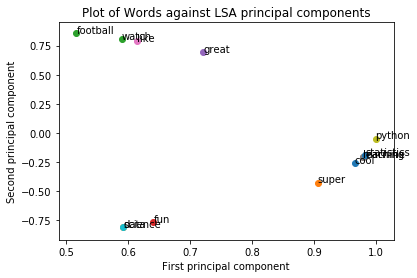

In [15]:
plt.figure()
ax = plt.gca()
for pos, vec in enumerate(list(zip(Vxs, Vys))[:]):
    ax.scatter(vec[0],vec[1])
    ax.text(vec[0],vec[1],s=vectorizer.get_feature_names()[pos])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of Words against LSA principal components')
plt.show()

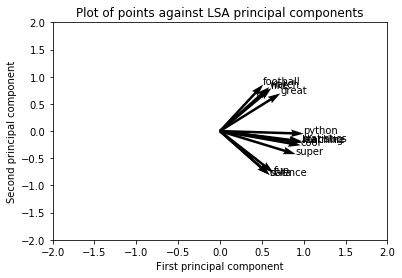

[(0, 'cool'), (1, 'data'), (2, 'football'), (3, 'fun'), (4, 'great'), (5, 'learning'), (6, 'like'), (7, 'machine'), (8, 'python'), (9, 'science'), (10, 'statistics'), (11, 'super'), (12, 'watch')]


In [16]:
plt.figure()
ax = plt.gca()
for pos, vec in enumerate(list(zip(Vxs, Vys))[:]):
    ax.quiver(0,0,vec[0],vec[1],angles='xy',scale_units='xy',scale=1, linewidth = .01, norm=True)
    ax.text(vec[0],vec[1],s=vectorizer.get_feature_names()[pos])
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of points against LSA principal components')
plt.draw()
plt.show()
print(list(enumerate(vectorizer.get_feature_names())))

In [17]:
#Compute vectors similarity using LSA components
Vsimilarity = np.asarray(np.asmatrix(components) * np.asmatrix(components).T)
pd.DataFrame(Vsimilarity,index=vectorizer.get_feature_names(), columns=vectorizer.get_feature_names());

In [18]:
xs = [w[0] for w in wtm_lsa]
ys = [w[1] for w in wtm_lsa]
xs, ys;

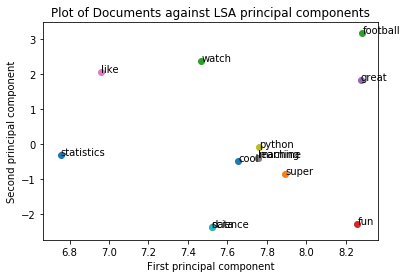

In [19]:
plt.figure()
ax = plt.gca()
for pos, vec in enumerate(list(zip(xs, ys))[:]):
    ax.scatter(vec[0],vec[1])
    ax.text(vec[0],vec[1],s=vectorizer.get_feature_names()[pos])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of Documents against LSA principal components')
plt.show()

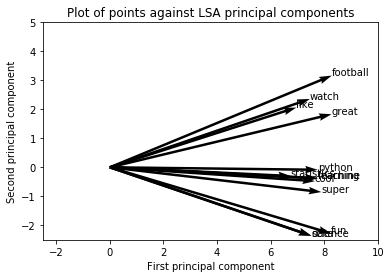

[(0, 'cool'), (1, 'data'), (2, 'football'), (3, 'fun'), (4, 'great'), (5, 'learning'), (6, 'like'), (7, 'machine'), (8, 'python'), (9, 'science'), (10, 'statistics'), (11, 'super'), (12, 'watch')]


In [20]:
plt.figure()
ax = plt.gca()
for pos, vec in enumerate(list(zip(xs, ys))[:]):
    ax.quiver(0,0,vec[0],vec[1],angles='xy',scale_units='xy',scale=1, linewidth = .01)
    ax.text(vec[0],vec[1],s=vectorizer.get_feature_names()[pos])
ax.set_xlim([-2.5,10])
ax.set_ylim([-2.5,5])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of points against LSA principal components')
plt.show()
print(list(enumerate(vectorizer.get_feature_names())))

In [21]:
W_embeddings = (wtm_lsa + wlsa.components_.T)/2

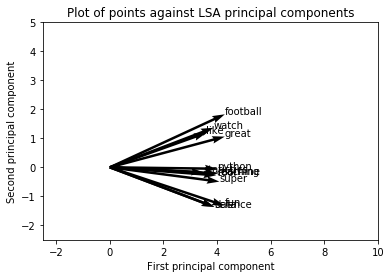

[(0, 'cool'), (1, 'data'), (2, 'football'), (3, 'fun'), (4, 'great'), (5, 'learning'), (6, 'like'), (7, 'machine'), (8, 'python'), (9, 'science'), (10, 'statistics'), (11, 'super'), (12, 'watch')]


In [22]:
plt.figure()
ax = plt.gca()
for pos, vec in enumerate((W_embeddings.tolist())[:]):
    ax.quiver(0,0,vec[0],vec[1],angles='xy',scale_units='xy',scale=1, linewidth = .01)
    ax.text(vec[0],vec[1],s=vectorizer.get_feature_names()[pos])
ax.set_xlim([-2.5,10])
ax.set_ylim([-2.5,5])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of points against LSA principal components')
plt.show()
print(list(enumerate(vectorizer.get_feature_names())))

In [23]:
# Fit LSA. Use algorithm = “randomized” for large datasets
lsa = TruncatedSVD(2, algorithm='arpack')
dtm_lsa = lsa.fit_transform(create_dtm_pmi_matrix(dtm.toarray().T))

In [24]:
pd.DataFrame(dtm_lsa, index = vectorizer.get_feature_names(), columns = ["component_" + str(i) for i in range(1,lsa.n_components+1,1)])

,component_1,component_2
cool,5.8796,-0.5832
data,5.3923,-1.6980
football,6.0428,2.7126
fun,5.7898,-1.6747
great,5.7836,1.1897
learning,5.6542,-0.4225
like,5.5138,2.0473
machine,5.6542,-0.4225
python,5.6234,-0.2084
science,5.3923,-1.6980


In [25]:
components = np.transpose(dtm_lsa)
#components = sklearn.preprocessing.normalize(components, axis=0, norm='l2')

In [26]:
Vxs = [w for w in components[0]]
Vys = [w for w in components[1]]

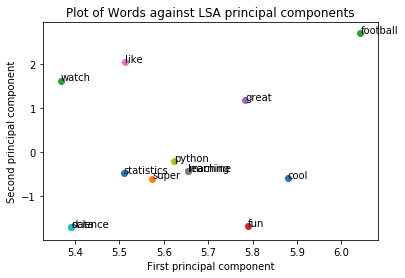

[(0, 'cool'), (1, 'data'), (2, 'football'), (3, 'fun'), (4, 'great'), (5, 'learning'), (6, 'like'), (7, 'machine'), (8, 'python'), (9, 'science'), (10, 'statistics'), (11, 'super'), (12, 'watch')]


In [27]:
plt.figure()
ax = plt.gca()
for pos, vec in enumerate(list(zip(Vxs, Vys))[:]):
    ax.scatter(vec[0],vec[1])
    ax.text(vec[0],vec[1],s=vectorizer.get_feature_names()[pos])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of Words against LSA principal components')
plt.show()
print(list(enumerate(vectorizer.get_feature_names())))

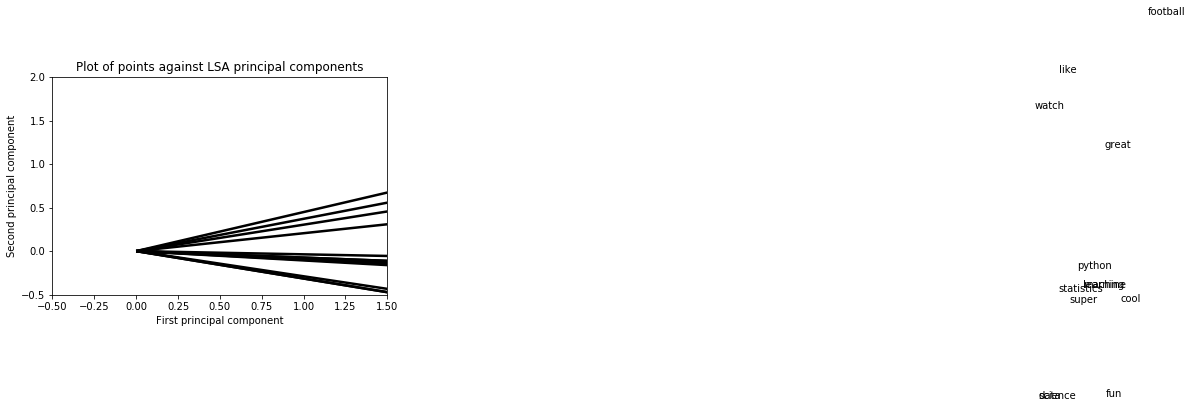

[(0, 'cool'), (1, 'data'), (2, 'football'), (3, 'fun'), (4, 'great'), (5, 'learning'), (6, 'like'), (7, 'machine'), (8, 'python'), (9, 'science'), (10, 'statistics'), (11, 'super'), (12, 'watch')]


In [28]:
plt.figure()
ax = plt.gca()
for pos, vec in enumerate(list(zip(Vxs, Vys))[:]):
    ax.quiver(0,0,vec[0],vec[1],angles='xy',scale_units='xy',scale=1, linewidth = .01, norm=True)
    ax.text(vec[0],vec[1],s=vectorizer.get_feature_names()[pos])
ax.set_xlim([-.5,1.5])
ax.set_ylim([-.5,2])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of points against LSA principal components')
plt.draw()
plt.show()
print(list(enumerate(vectorizer.get_feature_names())))

In [29]:
pd.DataFrame(lsa.components_, columns = example, index = ["component_" + str(i) for i in range(1,lsa.n_components+1,1)])

,Machine learning is super fun,Python is super super cool,Statistics is cool too,Python is great for machine learning,Data science is fun,I like football,Football is great to watch
component_1,0.3806,0.3644,0.3676,0.3863,0.3924,0.3687,0.3848
component_2,-0.2357,-0.1234,-0.1402,-0.0020,-0.5651,0.5625,0.5232


In [30]:
components = np.transpose(lsa.components_)
components = sklearn.preprocessing.normalize(components, axis=1, norm='l2')

In [31]:
xs = [w[0] for w in components]
ys = [w[1] for w in components]
xs, ys;

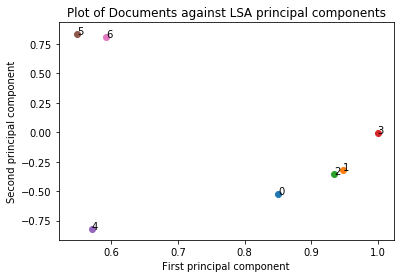

[(0, 'Machine learning is super fun'), (1, 'Python is super super cool'), (2, 'Statistics is cool too'), (3, 'Python is great for machine learning'), (4, 'Data science is fun'), (5, 'I like football'), (6, 'Football is great to watch')]


In [32]:
plt.figure()
ax = plt.gca()
for pos, vec in enumerate(list(zip(xs, ys))[:]):
    ax.scatter(vec[0],vec[1])
    ax.text(vec[0],vec[1],s=pos)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of Documents against LSA principal components')
plt.show()
print(list(enumerate(example)))

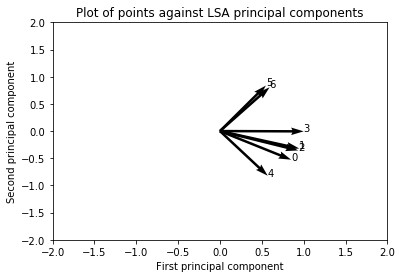

[(0, 'Machine learning is super fun'), (1, 'Python is super super cool'), (2, 'Statistics is cool too'), (3, 'Python is great for machine learning'), (4, 'Data science is fun'), (5, 'I like football'), (6, 'Football is great to watch')]


In [33]:
plt.figure()
ax = plt.gca()
for pos, vec in enumerate(list(zip(xs, ys))[:]):
    ax.quiver(0,0,vec[0],vec[1],angles='xy',scale_units='xy',scale=1, linewidth = .01)
    ax.text(vec[0],vec[1],s=pos)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of points against LSA principal components')
plt.draw()
plt.show()
print(list(enumerate(example)))

In [34]:
#Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(components) * np.asmatrix(components).T)
pd.DataFrame(similarity,index=example, columns=example)

,Machine learning is super fun,Python is super super cool,Statistics is cool too,Python is great for machine learning,Data science is fun,I like football,Football is great to watch
Machine learning is super fun,1.0000,0.9741,0.9820,0.8529,0.9173,0.0258,0.0796
Python is super super cool,0.9741,1.0000,0.9993,0.9488,0.8036,0.2511,0.3028
Statistics is cool too,0.9820,0.9993,1.0000,0.9362,0.8256,0.2142,0.2665
Python is great for machine learning,0.8529,0.9488,0.9362,1.0000,0.5746,0.5439,0.5883
Data science is fun,0.9173,0.8036,0.8256,0.5746,1.0000,-0.3743,-0.3238
I like football,0.0258,0.2511,0.2142,0.5439,-0.3743,1.0000,0.9985
Football is great to watch,0.0796,0.3028,0.2665,0.5883,-0.3238,0.9985,1.0000


In [85]:
out = create_dtm_pmi_matrix(create_dtm_pmi_matrix(M.toarray().T) @ create_dtm_pmi_matrix(dtm.toarray().T))

In [86]:
# Fit LSA. Use algorithm = “randomized” for large datasets
lsa = TruncatedSVD(2, algorithm='arpack')
dtm_lsa = lsa.fit_transform(create_dtm_pmi_matrix(dtm.toarray().T))

In [87]:
pd.DataFrame(dtm_lsa, index = vectorizer.get_feature_names(), columns = ["component_" + str(i) for i in range(1,lsa.n_components+1,1)])

,component_1,component_2
cool,5.8796,-0.5832
data,5.3923,-1.6980
football,6.0428,2.7126
fun,5.7898,-1.6747
great,5.7836,1.1897
learning,5.6542,-0.4225
like,5.5138,2.0473
machine,5.6542,-0.4225
python,5.6234,-0.2084
science,5.3923,-1.6980


In [88]:
components = np.transpose(dtm_lsa)
#components = sklearn.preprocessing.normalize(components, axis=0, norm='l2')

In [89]:
Vxs = [w for w in components[0]]
Vys = [w for w in components[1]]

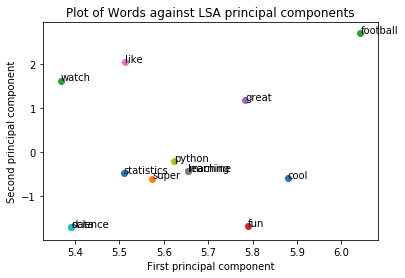

[(0, 'cool'), (1, 'data'), (2, 'football'), (3, 'fun'), (4, 'great'), (5, 'learning'), (6, 'like'), (7, 'machine'), (8, 'python'), (9, 'science'), (10, 'statistics'), (11, 'super'), (12, 'watch')]


In [90]:
plt.figure()
ax = plt.gca()
for pos, vec in enumerate(list(zip(Vxs, Vys))[:]):
    ax.scatter(vec[0],vec[1])
    ax.text(vec[0],vec[1],s=vectorizer.get_feature_names()[pos])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of Words against LSA principal components')
plt.show()
print(list(enumerate(vectorizer.get_feature_names())))

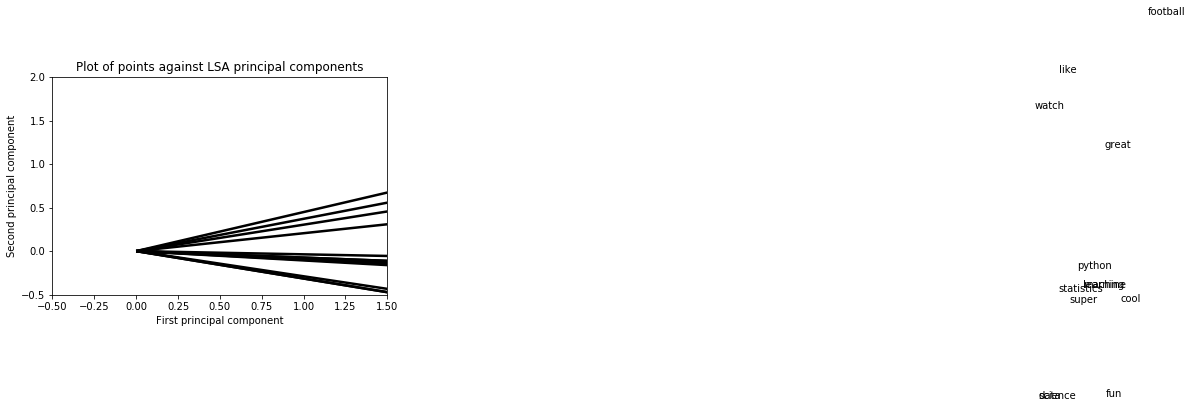

[(0, 'cool'), (1, 'data'), (2, 'football'), (3, 'fun'), (4, 'great'), (5, 'learning'), (6, 'like'), (7, 'machine'), (8, 'python'), (9, 'science'), (10, 'statistics'), (11, 'super'), (12, 'watch')]


In [91]:
plt.figure()
ax = plt.gca()
for pos, vec in enumerate(list(zip(Vxs, Vys))[:]):
    ax.quiver(0,0,vec[0],vec[1],angles='xy',scale_units='xy',scale=1, linewidth = .01, norm=True)
    ax.text(vec[0],vec[1],s=vectorizer.get_feature_names()[pos])
ax.set_xlim([-.5,1.5])
ax.set_ylim([-.5,2])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of points against LSA principal components')
plt.draw()
plt.show()
print(list(enumerate(vectorizer.get_feature_names())))

In [92]:
pd.DataFrame(lsa.components_, columns = example, index = ["component_" + str(i) for i in range(1,lsa.n_components+1,1)])

,Machine learning is super fun,Python is super super cool,Statistics is cool too,Python is great for machine learning,Data science is fun,I like football,Football is great to watch
component_1,0.3806,0.3644,0.3676,0.3863,0.3924,0.3687,0.3848
component_2,-0.2357,-0.1234,-0.1402,-0.0020,-0.5651,0.5625,0.5232


In [93]:
components = np.transpose(lsa.components_)
components = sklearn.preprocessing.normalize(components, axis=1, norm='l2')

In [94]:
xs = [w[0] for w in components]
ys = [w[1] for w in components]
xs, ys;

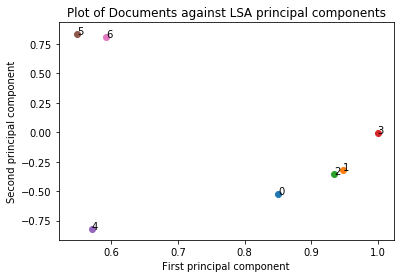

[(0, 'Machine learning is super fun'), (1, 'Python is super super cool'), (2, 'Statistics is cool too'), (3, 'Python is great for machine learning'), (4, 'Data science is fun'), (5, 'I like football'), (6, 'Football is great to watch')]


In [95]:
plt.figure()
ax = plt.gca()
for pos, vec in enumerate(list(zip(xs, ys))[:]):
    ax.scatter(vec[0],vec[1])
    ax.text(vec[0],vec[1],s=pos)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of Documents against LSA principal components')
plt.show()
print(list(enumerate(example)))

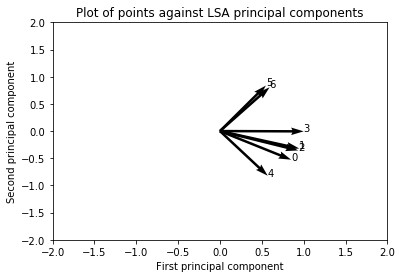

[(0, 'Machine learning is super fun'), (1, 'Python is super super cool'), (2, 'Statistics is cool too'), (3, 'Python is great for machine learning'), (4, 'Data science is fun'), (5, 'I like football'), (6, 'Football is great to watch')]


In [96]:
plt.figure()
ax = plt.gca()
for pos, vec in enumerate(list(zip(xs, ys))[:]):
    ax.quiver(0,0,vec[0],vec[1],angles='xy',scale_units='xy',scale=1, linewidth = .01)
    ax.text(vec[0],vec[1],s=pos)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of points against LSA principal components')
plt.draw()
plt.show()
print(list(enumerate(example)))

In [97]:
#Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(components) * np.asmatrix(components).T)
pd.DataFrame(similarity,index=example, columns=example)

,Machine learning is super fun,Python is super super cool,Statistics is cool too,Python is great for machine learning,Data science is fun,I like football,Football is great to watch
Machine learning is super fun,1.0000,0.9741,0.9820,0.8529,0.9173,0.0258,0.0796
Python is super super cool,0.9741,1.0000,0.9993,0.9488,0.8036,0.2511,0.3028
Statistics is cool too,0.9820,0.9993,1.0000,0.9362,0.8256,0.2142,0.2665
Python is great for machine learning,0.8529,0.9488,0.9362,1.0000,0.5746,0.5439,0.5883
Data science is fun,0.9173,0.8036,0.8256,0.5746,1.0000,-0.3743,-0.3238
I like football,0.0258,0.2511,0.2142,0.5439,-0.3743,1.0000,0.9985
Football is great to watch,0.0796,0.3028,0.2665,0.5883,-0.3238,0.9985,1.0000
